# `RandomForestClassifier` - HyperparameterTuning

In [32]:
from sklearn.ensemble import RandomForestClassifier
from src.preprocessing import Passthrough
from sklearn.pipeline import Pipeline, make_pipeline
from src.utils import print_params
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

import matplotlib.pyplot as plt

## Load the data

In [33]:
import pandas as pd
import numpy as np
from src.utils import load_data
df = load_data()
dfX, dfy = load_data(return_X_y=True)

## Import the `DataPipeline`

In [34]:
from src.pipeline import dp2 as dp

In [35]:
dp.get_description(markdown=True)


1. `Embarked`: Dropped NA rows and applied OneHotEncoding
2. `Age`: Mean imputation with SimpleImputer 
3. `Sex`: OneHotEncoding
4. `Name`: Categorised into ['Mr', 'Mrs', 'Miss', 'Master', 'Special']<br/> 
    5.1 Rename [Mlle, Ms] -> Miss      
    5.2 Rename [Mme] -> Mrs     
    5.3 Put the Rest -> other     
    Then performed OneHotEncoding
5. `Ticket`: categorized into [1: numeric, 0: else] <br/>
    6.1 Remove special characters but not space <br/>
    6.2 Replace numeric strings by 'numeric' <br/>
    6.3 Split on space and keep the first item <br/>
 Then applied binarizer for [1: numeric, 0: else]
6. `SibSp`: binned into [0, 1, >1] using SibSpBinner
7. `Parch`: binned into [0, 1, >1] using ParchBinner
8. Scaling all features at the last using StandardScaler

**MLmodel:** `SVC`


In [36]:
dp.mlmodel = RandomForestClassifier(random_state=1, oob_score=True)
pipe = dp.get_pipeline()

## Fit the `RandomForestClassifer` and get the `tree`

In [146]:
from src.utils import get_training_cv_score, get_best_param_score
from sklearn.model_selection import RepeatedStratifiedKFold
skf = StratifiedKFold(n_splits=5)
rskf = RepeatedStratifiedKFold(n_repeats=3, random_state=1)
import sklearn

In [45]:
pipe.fit(dfX, dfy);

In [46]:
ml = pipe.named_steps['ml']

In [47]:
ml.oob_score_

0.819304152637486

In [147]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [150]:
get_training_cv_score(pipe, dfX, dfy, cv=skf, scoring='f1')

Training score: 0.9012345679012346
crossvalidation score: 0.7602224181479184


## Generate the `param_grid`

In [151]:
from src.tune import load_hyperparams_mlmodel
from sklearn.model_selection import ParameterGrid
from src.utils import get_training_cv_score, get_best_param_score

In [152]:
hyperparams = load_hyperparams_mlmodel()
hyperparams['RandomForestClassifier']

{'ml': [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False)],
 'ml__max_depth': array([ 4.,  7., 12., 21., 35.]),
 'ml__min_samples_split': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
 'ml__min_samples_leaf': [2, 5, 10, 20, 40],
 'ml__max_features': ['sqrt', 'log2', None, 0.1, 0.3, 0.5, 0.7],
 'ml__bootstrap': [True, False],
 'ml__n_estimators': [10, 50, 100, 500, 1000],
 'ml__oob_score': [True, False]}

In [154]:
param_grid = {'ml': [RandomForestClassifier(random_state=1)],
              'ml__max_depth': [4.0, 6.0, 8.0, 12.0, 16.0, None],
              'ml__min_samples_split': [2, 5, 10],
              'ml__min_samples_leaf': [2, 5, 10, 20, 40],
              'ml__max_features': ['sqrt'],
              'ml__n_estimators': [10, 50, 100, 200]
             }

### Check the length of the `param_grid`. Is it too big for `GridSearchCV`?

In [155]:
len(ParameterGrid(param_grid))

360

## `RandomizedSearchCV`

In [157]:
%%time
grid_search = GridSearchCV(pipe, param_grid, cv=skf, return_train_score=True, 
                           scoring=['accuracy', 'f1', 'roc_auc', 
                                    'precision', 'recall'], refit='f1')
grid_search.fit(dfX, dfy)
get_best_param_score(grid_search)

Best param: {'ml': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12.0, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False), 'ml__max_depth': 12.0, 'ml__max_features': 'sqrt', 'ml__min_samples_leaf': 2, 'ml__min_samples_split': 5, 'ml__n_estimators': 10}
Best score: 0.7671135478757983
CPU times: user 12min 52s, sys: 4.58 s, total: 12min 56s
Wall time: 13min 11s


In [158]:
pipe = grid_search.best_estimator_
get_training_cv_score(pipe, dfX, dfy, cv=skf)

Training score: 0.9012345679012346
crossvalidation score: 0.8350260498399347


In [303]:
from src.featurization import NameTitleExtractor, CabinTypeExtractor, TicketTypeExtractor
from src.featurization import SibSpBinner, ParchBinner 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from src.preprocessing import NaNDropper
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.svm import LinearSVC, SVC

from src.featurization import familySize, numCabin


prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])


imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder())
])


preprocess_noscale = ColumnTransformer([
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp', SimpleImputer(), ['Age', 'Fare']),
    ('pre_Name', NameTitleExtractor(), 'Name'),
    ('cabin_type', CabinTypeExtractor(), 'Cabin'),
    ('pre_Ticket', 'drop', 'Ticket'),
    ('pre_SibSp', SibSpBinner(), ['SibSp']),
    ('pre_Parch', ParchBinner(), ['Parch']),
#     ('familySize', familySize, ['SibSp', 'Parch']),
    ('numCabin', numCabin, 'Cabin')
], 
    'passthrough')

preprocess_data = Pipeline([
    ('clmn_trnsfrm', preprocess_noscale),
    ('scale', StandardScaler()),
#     ('feat_sel', SelectFromModel(LinearSVC(penalty='l1', dual=False)))
])

In [308]:
pipe.set_params(preprocess=preprocess_data);

In [309]:
pipe.fit(dfX, dfy);

In [310]:
get_training_cv_score(pipe, dfX, dfy, cv=skf, scoring='accuracy')

Training score: 0.856341189674523
crossvalidation score: 0.824913690289373


In [82]:
res = pd.DataFrame(grid_search.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__min_samples_split,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046805,0.016277,0.018404,0.001603,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4,sqrt,2,2,10,"{'ml': (DecisionTreeClassifier(ccp_alpha=0.0, ...",0.748603,0.808989,0.803371,0.780899,0.808989,0.790170,0.023222,317
1,0.085171,0.000549,0.020508,0.000649,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4,sqrt,2,2,50,"{'ml': (DecisionTreeClassifier(ccp_alpha=0.0, ...",0.832402,0.820225,0.814607,0.780899,0.837079,0.817042,0.019798,109
2,0.147496,0.009309,0.026879,0.003377,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4,sqrt,2,2,100,"{'ml': (DecisionTreeClassifier(ccp_alpha=0.0, ...",0.832402,0.820225,0.820225,0.780899,0.842697,0.819289,0.020954,81
3,0.264358,0.009485,0.030988,0.000861,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4,sqrt,2,2,200,"{'ml': (DecisionTreeClassifier(ccp_alpha=0.0, ...",0.815642,0.820225,0.820225,0.780899,0.837079,0.814814,0.018467,138
4,0.037328,0.000789,0.017205,0.000810,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4,sqrt,2,5,10,"{'ml': (DecisionTreeClassifier(ccp_alpha=0.0, ...",0.737430,0.808989,0.803371,0.797753,0.808989,0.791306,0.027258,316


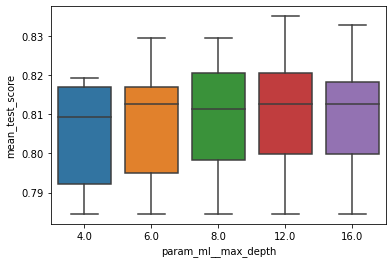

In [83]:
sns.boxplot(x='param_ml__max_depth', y='mean_test_score', data=res)

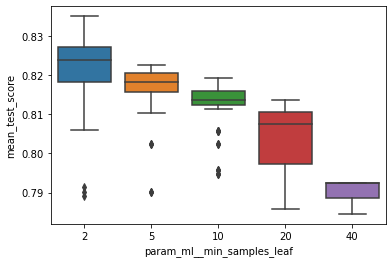

In [84]:
sns.boxplot(x='param_ml__min_samples_leaf', y='mean_test_score', data=res)

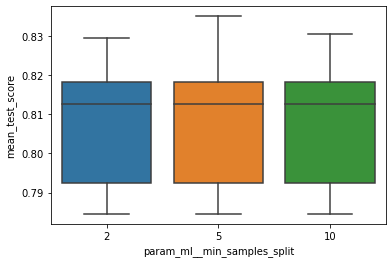

In [90]:
sns.boxplot(x='param_ml__min_samples_split', y='mean_test_score', data=res)

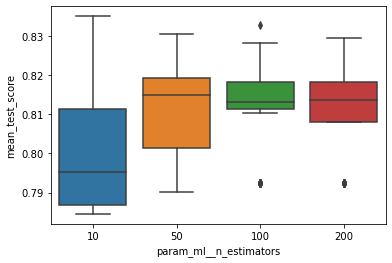

In [92]:
sns.boxplot(x='param_ml__n_estimators', y='mean_test_score', data=res)

In [85]:
def plot_joint_heatmap(gs, x, y, values='mean_test_score', **kwargs):
    pvt = res.pivot_table(values=values, 
                          index=f'param_{x}', 
                          columns=f'param_{y}')
    
    return sns.heatmap(pvt)
    
def plot_joint_heatmap_model(gs, x, y, model_step='ml', values='mean_test_score', **kwargs):
    return plot_joint_heatmap(gs, x=f'{model_step}__{x}',
                              y=f'{model_step}__{y}', values=values, **kwargs)
    

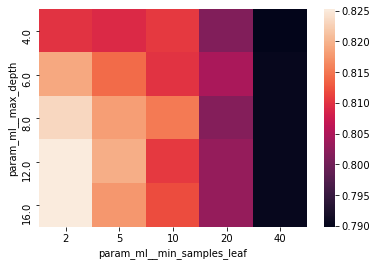

In [87]:
plot_joint_heatmap_model(grid_search, 'max_depth', 'min_samples_leaf')

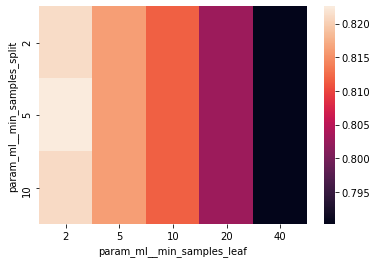

In [88]:
plot_joint_heatmap_model(grid_search, 'min_samples_split', 'min_samples_leaf')

In [112]:
get_training_cv_score(pipe, dfX, dfy, cv=skf)

Training score: 0.9012345679012346
crossvalidation score: 0.8294017952419811


In [113]:
from src.utils import print_params
print_params(pipe.named_steps['ml'])

['bootstrap',
 'ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']


In [104]:
get_training_cv_score(pipe, dfX, dfy, cv=skf)

Training score: 0.9012345679012346
crossvalidation score: 0.8294017952419811


In [135]:
gs = GridSearchCV(pipe, {'ml__min_samples_leaf': [2]}, cv=skf).fit(dfX, dfy)
get_best_param_score(gs)

Best param: {'ml__min_samples_leaf': 2}
Best score: 0.8294017952419811


In [140]:
from src.utils import create_submission, get_submission_name

In [137]:
from src.utils import load_data
dfX_test = load_data('test')

In [138]:
pred = pipe.predict(dfX_test)

In [142]:
outname = get_submission_name(dp, True)

In [143]:
create_submission(pred, outname)

Created submission file at /home/abhi/main/coding/Python-code/mygit/Titanic-Survival/data/submission/dp2_1705201902_submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## See how these best params perform in the other pipeline

In [73]:
from src.pipeline import dp1 

In [75]:
dp1.mlmodel = RandomForestClassifier(random_state=1)
pipe1 = dp1.get_pipeline()

### Training score and crossvalidate accuracy with best params of dp1

In [77]:
pipe1.fit(dfX, dfy)
get_training_cv_score(pipe1, dfX, dfy, cv=rskf)

Training score: 1.0
crossvalidation score: 0.8241709036888248


In [78]:
pipe1.set_params(**grid_search.best_params_);

### Training score and crossvalidate accuracy with best params of dp1

In [81]:
pipe1.fit(dfX, dfy)
get_training_cv_score(pipe1, dfX, dfy, cv=skf)

Training score: 0.9113355780022446
crossvalidation score: 0.8215617349821104


### Performing new `GridSearchCV` for dp2

dp2 has more redundant features aka more overfitting, hence we can try
- lesser max_depth
- lesser max_features
- higher min_samples_leaf
- higher min_samples_split

In [108]:
%%time
gs = GridSearchCV(pipe2, param_grid, cv=skf).fit(dfX, dfy)

get_best_param_score(gs)

Best param: {'ml': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12.0, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'ml__max_depth': 12.0, 'ml__max_features': 0.8, 'ml__min_samples_leaf': 10, 'ml__min_samples_split': 2}
Best score: 0.8282656455966354
CPU times: user 1min 23s, sys: 181 ms, total: 1min 23s
Wall time: 1min 24s


In [177]:
pipe2 = gs.best_estimator_

<module 'matplotlib.pyplot' from '/home/abhi/miniconda3/envs/titansurv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

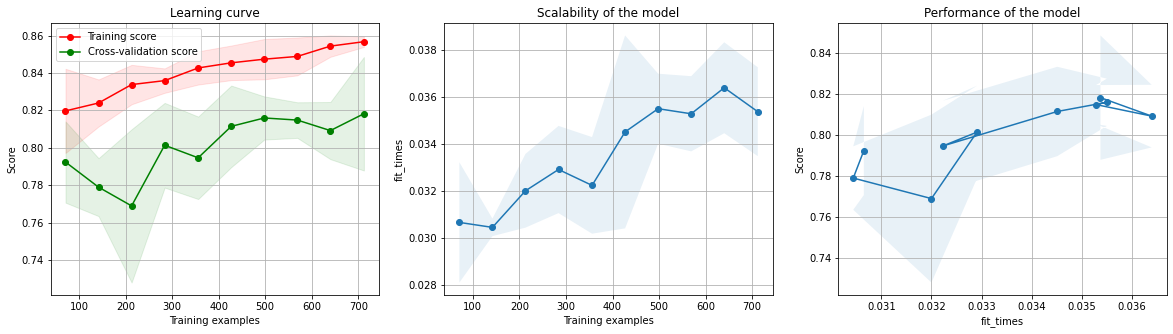

In [188]:
plot_learning_curve(pipe2, 'Learning curve', dfX, dfy, cv=skf, train_sizes=np.linspace(0.1, 1.0, 10))

## Keep a record of a file to store best params of every model you tune

In [60]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt